# BlueTrails AI - Water Quality Prediction Model

**Objective**: Build a deep learning regression model to predict 5 water quality parameters:
- CHL_A (Chlorophyll A)
- Turb (Turbidity)
- DO_mg (Dissolved Oxygen)
- N_TOTAL (Total Nitrogen)
- Temperature

**Inputs**: site_id + date (future dates)

**Approach**: Internal model using only EPA dataset features

## 1. Setup & Import Libraries

In [ ]:
# Install required packages (run once)
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install supabase pandas numpy scikit-learn matplotlib seaborn python-dotenv
# %pip install supabase

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supabase
from supabase import create_client, Client

# Set random seeds for reproducibility
np.random.seed(34328637)
torch.manual_seed(34328637)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cpu
Device: CPU


## 2. Load Data from Supabase Database

In [2]:
# Load environment variables from .env file
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

# Initialize Supabase client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


In [3]:
# Fetch data from the wide format view (contains all parameters in columns)
# This view has: site_id, date, measurement_type, chl_a, turbidity, do_mg_l, n_total, temp_sensor/temp_lab, etc.

response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_raw = pd.DataFrame(response.data)

print(f"Loaded {len(df_raw)} records from database")
print(f"Columns: {df_raw.columns.tolist()}")
df_raw.head()

Loaded 5853 records from database
Columns: ['site_id', 'site_name_short', 'water_body_name', 'date', 'measurement_type', 'latitude', 'longitude', 'chl_a', 'secchi_depth_m', 'turbidity', 'tss', 'temp_sensor', 'temp_lab', 'do_mg_l', 'do_saturation', 'salinity', 'ph', 'fluorescence', 'par', 'n_ammonia', 'n_nitrite', 'n_nitrate', 'n_nox', 'n_total', 'p_phosphate', 'p_total', 'silicate']


,site_id,site_name_short,water_body_name,date,measurement_type,latitude,longitude,chl_a,secchi_depth_m,turbidity,...,fluorescence,par,n_ammonia,n_nitrite,n_nitrate,n_nox,n_total,p_phosphate,p_total,silicate
0,1229,Central,Port Phillip Bay,2025-06-20,surface,-38.057034,144.870407,0.5,NaN,0.5044,...,2.4550,567.360,5.0,1.0,6.0,7.0,150.0,46.0,60.0,150.0
1,939,Corio,Port Phillip Bay,2025-06-20,surface,-38.076981,145.115005,1.1,NaN,0.4858,...,3.8880,119.640,10.0,2.0,17.0,19.0,270.0,78.0,90.0,200.0
2,1991,DMG (B),Port Phillip Bay,2025-06-20,surface,-37.870190,144.933807,1.1,NaN,0.8913,...,4.6226,386.180,9.0,2.0,14.0,16.0,240.0,69.0,80.0,170.0
3,1282,Dromana,Port Phillip Bay,2025-06-20,surface,-38.303406,144.991318,0.5,NaN,0.5670,...,2.8738,288.590,5.0,1.0,5.0,6.0,200.0,58.0,70.0,150.0
4,1911,Hobsons Bay,Port Phillip Bay,2025-06-20,surface,-38.100967,144.398727,0.3,NaN,0.8170,...,3.2659,88.754,8.0,2.0,8.0,10.0,230.0,71.0,80.0,270.0


In [4]:
# Fetch site metadata for additional features (lat/long, water body)
response_sites = supabase.table('v_epa_sites').select('*').execute()
df_sites = pd.DataFrame(response_sites.data)

print(f"Loaded {len(df_sites)} sites")
df_sites.head()

Loaded 21 sites


,site_id,site_name_short,site_name_long,water_body_name,latitude,longitude,created_at,updated_at
0,2316,Lake King North,Lake King North,Gippsland Lakes,-37.857114,147.708537,2025-10-01T11:00:28.058762+00:00,2025-10-01T11:00:28.058762+00:00
1,2314,Lake King South,Lake King South,Gippsland Lakes,-37.886953,147.722339,2025-10-01T11:00:28.058762+00:00,2025-10-01T11:00:28.058762+00:00
2,2350,Lake Reeve East,Lake Reeve East,Gippsland Lakes,-38.010695,147.658541,2025-10-01T11:00:28.058762+00:00,2025-10-01T11:00:28.058762+00:00
3,2351,Lake Reeve West,Lake Reeve West,Gippsland Lakes,-38.306087,147.260918,2025-10-01T11:00:28.058762+00:00,2025-10-01T11:00:28.058762+00:00
4,2311,Lake Victoria,Lake Victoria,Gippsland Lakes,-37.991922,147.625416,2025-10-01T11:00:28.058762+00:00,2025-10-01T11:00:28.058762+00:00


## 3. Data Exploration & Understanding

In [5]:
# Basic info
print("=== Dataset Info ===")
print(f"Shape: {df_raw.shape}")
print(f"\nData types:\n{df_raw.dtypes}")
print(f"\nMissing values:\n{df_raw.isnull().sum()}")
print(f"\nDate range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"\nUnique sites: {df_raw['site_id'].nunique()}")
print(f"\nMeasurement types: {df_raw['measurement_type'].unique()}")

=== Dataset Info ===
Shape: (5853, 27)

Data types:
site_id              object
site_name_short      object
water_body_name      object
date                 object
measurement_type     object
latitude            float64
longitude           float64
chl_a               float64
secchi_depth_m      float64
turbidity           float64
tss                 float64
temp_sensor         float64
temp_lab            float64
do_mg_l             float64
do_saturation       float64
salinity            float64
ph                  float64
fluorescence        float64
par                 float64
n_ammonia           float64
n_nitrite           float64
n_nitrate           float64
n_nox               float64
n_total             float64
p_phosphate         float64
p_total             float64
silicate            float64
dtype: object

Missing values:
site_id                0
site_name_short        0
water_body_name        0
date                   0
measurement_type       0
latitude               0
longitude  

In [6]:
# Check target parameters availability
target_cols = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temp_sensor', 'temp_lab']

print("=== Target Parameter Statistics ===")
for col in target_cols:
    if col in df_raw.columns:
        non_null = df_raw[col].notna().sum()
        pct = (non_null / len(df_raw)) * 100
        print(f"{col:15} - {non_null:6} records ({pct:5.1f}%)")

=== Target Parameter Statistics ===
chl_a           -   5138 records ( 87.8%)
turbidity       -   2111 records ( 36.1%)
do_mg_l         -   5473 records ( 93.5%)
n_total         -   5723 records ( 97.8%)
temp_sensor     -   3365 records ( 57.5%)
temp_lab        -   2424 records ( 41.4%)


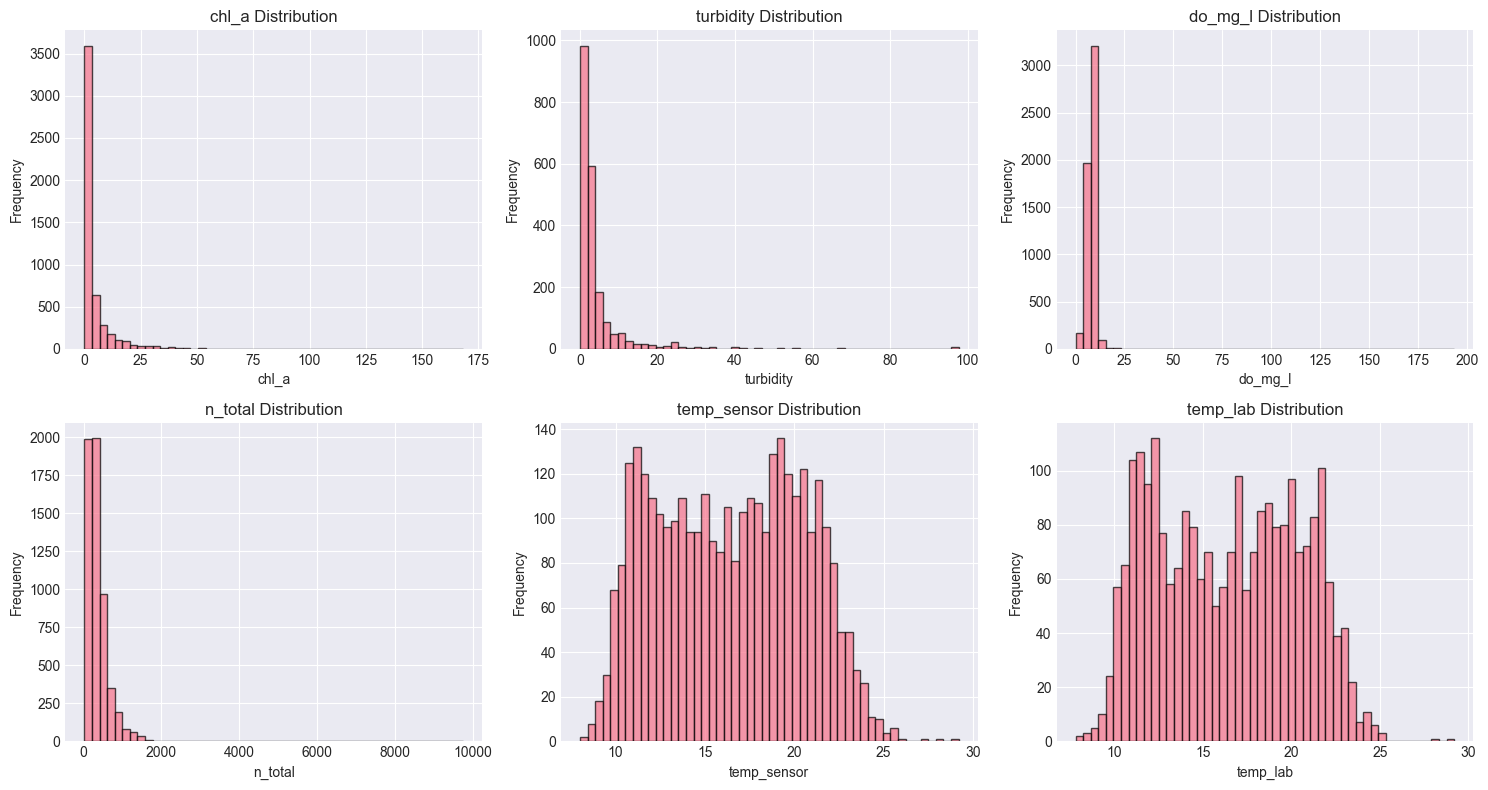

In [7]:
# Visualize target parameter distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(target_cols):
    if col in df_raw.columns and df_raw[col].notna().sum() > 0:
        axes[idx].hist(df_raw[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

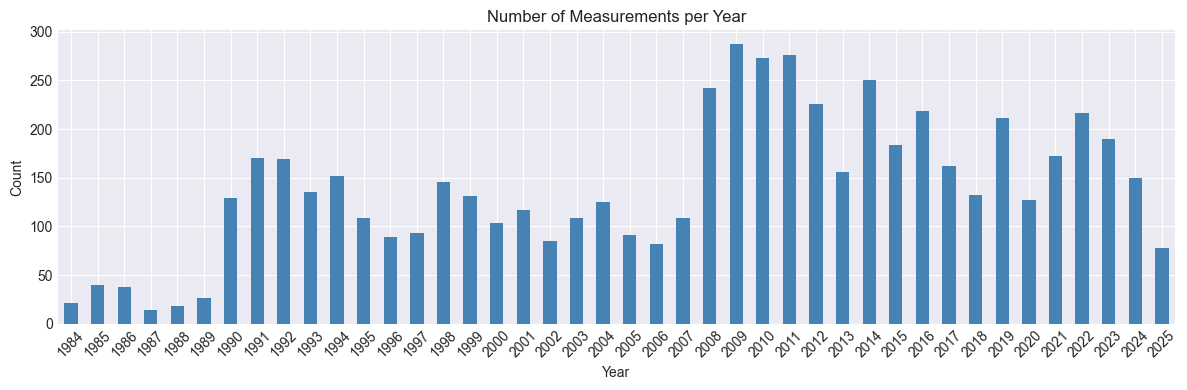

In [8]:
# Temporal distribution - measurements over time
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw['year'] = df_raw['date'].dt.year

plt.figure(figsize=(12, 4))
df_raw['year'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Number of Measurements per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

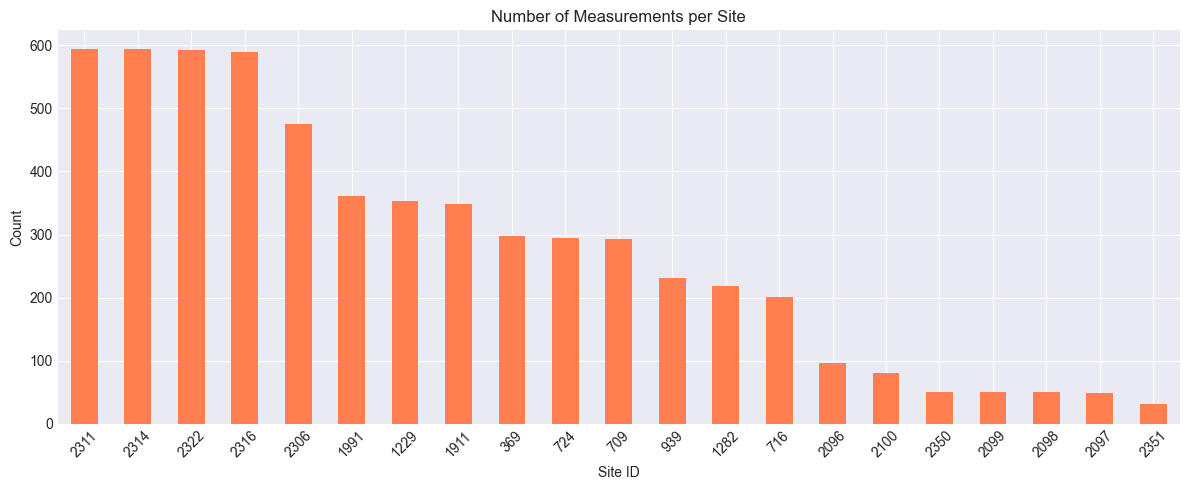

In [9]:
# Site distribution
plt.figure(figsize=(12, 5))
df_raw['site_id'].value_counts().plot(kind='bar', color='coral')
plt.title('Number of Measurements per Site')
plt.xlabel('Site ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing & Feature Engineering (Internal Model)

In [10]:
# Select relevant columns and create working dataframe
# We'll use 'surface' measurements only (type_id=1 or measurement_type='surface')
df = df_raw[df_raw['measurement_type'] == 'surface'].copy()

print(f"Filtered to surface measurements: {len(df)} records")

Filtered to surface measurements: 4492 records


In [11]:
# Merge with site metadata to get lat/long and water body info
df = df.merge(df_sites[['site_id', 'latitude', 'longitude', 'water_body_name']], 
              on='site_id', 
              how='left',
              suffixes=('', '_site'))

# Use latitude/longitude from site metadata if available
df['latitude'] = df['latitude_site'].fillna(df['latitude'])
df['longitude'] = df['longitude_site'].fillna(df['longitude'])
df = df.drop(['latitude_site', 'longitude_site'], axis=1, errors='ignore')

print(f"Merged with site metadata: {len(df)} records")
df.head()

Merged with site metadata: 4492 records


,site_id,site_name_short,water_body_name,date,measurement_type,latitude,longitude,chl_a,secchi_depth_m,turbidity,...,n_ammonia,n_nitrite,n_nitrate,n_nox,n_total,p_phosphate,p_total,silicate,year,water_body_name_site
0,1229,Central,Port Phillip Bay,2025-06-20,surface,-38.057034,144.870407,0.5,NaN,0.5044,...,5.0,1.0,6.0,7.0,150.0,46.0,60.0,150.0,2025,Port Phillip Bay
1,939,Corio,Port Phillip Bay,2025-06-20,surface,-38.076981,145.115005,1.1,NaN,0.4858,...,10.0,2.0,17.0,19.0,270.0,78.0,90.0,200.0,2025,Port Phillip Bay
2,1991,DMG (B),Port Phillip Bay,2025-06-20,surface,-37.870190,144.933807,1.1,NaN,0.8913,...,9.0,2.0,14.0,16.0,240.0,69.0,80.0,170.0,2025,Port Phillip Bay
3,1282,Dromana,Port Phillip Bay,2025-06-20,surface,-38.303406,144.991318,0.5,NaN,0.5670,...,5.0,1.0,5.0,6.0,200.0,58.0,70.0,150.0,2025,Port Phillip Bay
4,1911,Hobsons Bay,Port Phillip Bay,2025-06-20,surface,-38.100967,144.398727,0.3,NaN,0.8170,...,8.0,2.0,8.0,10.0,230.0,71.0,80.0,270.0,2025,Port Phillip Bay


In [12]:
# Define target parameters
# Temperature: use temp_sensor if available, otherwise temp_lab
df['temperature'] = df['temp_sensor'].fillna(df['temp_lab'])

TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

# Filter to rows with at least one target parameter
df = df[df[TARGET_PARAMS].notna().any(axis=1)].copy()

print(f"After filtering for target availability: {len(df)} records")
print(f"\nTarget parameter coverage:")
for param in TARGET_PARAMS:
    coverage = df[param].notna().sum() / len(df) * 100
    print(f"  {param:15} - {coverage:5.1f}%")

After filtering for target availability: 4490 records

Target parameter coverage:
  chl_a           -  98.7%
  turbidity       -  35.5%
  do_mg_l         -  94.7%
  n_total         -  98.8%
  temperature     -  92.0%


### Feature Engineering: Temporal Features

Extract meaningful time-based features from the date column.

In [13]:
# Temporal features from date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else      # Summer (Southern Hemisphere)
    2 if m in [3, 4, 5] else       # Autumn
    3 if m in [6, 7, 8] else       # Winter
    4                              # Spring
)

# Cyclic encoding for month and day_of_year (captures seasonality)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print("✓ Temporal features created")
print(f"Sample:\n{df[['date', 'year', 'month', 'season', 'month_sin', 'month_cos']].head()}")

✓ Temporal features created
Sample:
        date  year  month  season     month_sin  month_cos
0 2025-06-20  2025      6       3  1.224647e-16       -1.0
1 2025-06-20  2025      6       3  1.224647e-16       -1.0
2 2025-06-20  2025      6       3  1.224647e-16       -1.0
3 2025-06-20  2025      6       3  1.224647e-16       -1.0
4 2025-06-20  2025      6       3  1.224647e-16       -1.0


### Feature Engineering: Site-Specific Statistical Features

Calculate historical statistics per site for each parameter.

In [14]:
# Calculate site-level statistics for each target parameter
site_stats = df.groupby('site_id')[TARGET_PARAMS].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()

# Flatten multi-level columns
site_stats.columns = ['site_id'] + [f'{param}_{stat}' for param in TARGET_PARAMS for stat in ['mean', 'std', 'min', 'max', 'median']]

print(f"Site statistics calculated for {len(site_stats)} sites")
print(f"Statistical features: {len(site_stats.columns) - 1}")
site_stats.head()

Site statistics calculated for 21 sites
Statistical features: 25


,site_id,chl_a_mean,chl_a_std,chl_a_min,chl_a_max,chl_a_median,turbidity_mean,turbidity_std,turbidity_min,turbidity_max,...,n_total_mean,n_total_std,n_total_min,n_total_max,n_total_median,temperature_mean,temperature_std,temperature_min,temperature_max,temperature_median
0,1229,0.776852,0.532887,0.0,3.9358,0.67000,0.853242,0.800289,0.165900,5.550559,...,170.796193,48.955925,100.00,700.00,160.000,16.100393,3.812091,8.9,24.0,16.09785
1,1282,0.658564,0.671041,0.0,6.5738,0.50000,0.624876,0.521375,-0.012800,3.445400,...,165.953518,38.871511,100.00,300.00,160.216,16.199167,3.769788,8.8,23.3,16.34100
2,1911,0.926987,0.713956,0.0,5.1100,0.74550,1.218782,1.355804,0.087600,11.653193,...,223.273786,81.346244,25.00,1500.00,212.426,16.330284,4.096080,9.5,25.3,16.60000
3,1991,1.984981,1.597212,0.3,10.4600,1.60000,1.739822,1.228517,0.008100,7.721242,...,236.069462,77.358581,129.07,850.00,220.000,16.450025,4.096364,8.8,24.7,16.60000
4,2096,2.525055,2.162543,0.3,12.0000,1.68605,4.042426,3.245944,1.067749,14.618894,...,376.776134,195.658549,168.70,1235.57,320.000,17.037105,4.429158,9.4,24.6,16.63195


In [15]:
# Merge site statistics back to main dataframe
df = df.merge(site_stats, on='site_id', how='left')

print(f"✓ Site statistics merged: {df.shape}")

✓ Site statistics merged: (4490, 62)


### Feature Engineering: Lag Features

Create lagged values (previous measurement values) for time-series context.

In [16]:
# Sort by site and date for proper lag calculation
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Create lag features (previous 1, 2, 3 measurements per site)
lag_periods = [1, 2, 3]

for param in TARGET_PARAMS:
    for lag in lag_periods:
        df[f'{param}_lag{lag}'] = df.groupby('site_id')[param].shift(lag)

print(f"✓ Lag features created")
print(f"Total columns: {len(df.columns)}")

✓ Lag features created
Total columns: 77


### Feature Engineering: Rolling Statistics

Calculate rolling averages and trends.

In [17]:
# Rolling window statistics (7-day and 30-day averages)
windows = [7, 30]

for param in TARGET_PARAMS:
    for window in windows:
        df[f'{param}_rolling_mean_{window}d'] = df.groupby('site_id')[param].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{param}_rolling_std_{window}d'] = df.groupby('site_id')[param].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

print(f"✓ Rolling statistics created")
print(f"Total columns: {len(df.columns)}")

✓ Rolling statistics created
Total columns: 97


### Encode Categorical Features

In [18]:
# Label encode site_id
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

# Label encode water_body_name
water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

print(f"✓ Categorical encoding complete")
print(f"  Sites: {df['site_id'].nunique()} unique")
print(f"  Water bodies: {df['water_body_name'].nunique()} unique")

✓ Categorical encoding complete
  Sites: 21 unique
  Water bodies: 3 unique


### Prepare Feature Matrix and Target Variables

In [20]:
# Define feature columns (all engineered features)
FEATURE_COLS = [
    # Site info
    'site_id_encoded', 'water_body_encoded', 'latitude', 'longitude',
    
    # Temporal features
    'year', 'month', 'season', 'day_of_year',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    
    # Site statistics (mean, std, min, max, median for each target)
    # These will be auto-included based on column names
]

# Add all site statistical features
FEATURE_COLS += [col for col in df.columns if any(stat in col for stat in ['_mean', '_std', '_min', '_max', '_median'])]

# Add lag features
FEATURE_COLS += [col for col in df.columns if '_lag' in col]

# Add rolling features
FEATURE_COLS += [col for col in df.columns if '_rolling_' in col]

# Remove duplicates
FEATURE_COLS = list(set(FEATURE_COLS))

print(f"Total features: {len(FEATURE_COLS)}")
print(f"\nFeature categories:")
print(f"  Site & Location: {sum(1 for c in FEATURE_COLS if c in ['site_id_encoded', 'water_body_encoded', 'latitude', 'longitude'])}")
print(f"  Temporal: {sum(1 for c in FEATURE_COLS if any(t in c for t in ['year', 'month', 'season', 'day', 'sin', 'cos']))}")
print(f"  Site Statistics: {sum(1 for c in FEATURE_COLS if any(s in c for s in ['_mean', '_std', '_min', '_max', '_median']))}")
print(f"  Lag Features: {sum(1 for c in FEATURE_COLS if '_lag' in c)}")
print(f"  Rolling Features: {sum(1 for c in FEATURE_COLS if '_rolling_' in c)}")

Total features: 72

Feature categories:
  Site & Location: 4
  Temporal: 8
  Site Statistics: 45
  Lag Features: 15
  Rolling Features: 20


In [21]:
# Remove rows with NaN in features or targets
# For initial model, we'll use complete cases only
df_clean = df[FEATURE_COLS + TARGET_PARAMS + ['date', 'site_id']].dropna().copy()

print(f"Dataset after removing NaN: {len(df_clean)} records ({len(df_clean)/len(df)*100:.1f}% of filtered data)")

Dataset after removing NaN: 1211 records (27.0% of filtered data)


In [22]:
# Separate features and targets
X = df_clean[FEATURE_COLS].values
y = df_clean[TARGET_PARAMS].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1211, 72)
y shape: (1211, 5)


## 5. Train/Validation/Test Split

Use temporal split to avoid data leakage (not random split).

In [23]:
# Sort by date for temporal split
df_clean = df_clean.sort_values('date').reset_index(drop=True)
X = df_clean[FEATURE_COLS].values
y = df_clean[TARGET_PARAMS].values

# Temporal split: 70% train, 15% validation, 15% test
n = len(df_clean)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/n*100:.1f}%)")
print(f"Val set:   {X_val.shape[0]} samples ({X_val.shape[0]/n*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} samples ({X_test.shape[0]/n*100:.1f}%)")

print(f"\nDate ranges:")
print(f"  Train: {df_clean.iloc[:train_size]['date'].min()} to {df_clean.iloc[:train_size]['date'].max()}")
print(f"  Val:   {df_clean.iloc[train_size:train_size+val_size]['date'].min()} to {df_clean.iloc[train_size:train_size+val_size]['date'].max()}")
print(f"  Test:  {df_clean.iloc[train_size+val_size:]['date'].min()} to {df_clean.iloc[train_size+val_size:]['date'].max()}")

Train set: 847 samples (69.9%)
Val set:   181 samples (14.9%)
Test set:  183 samples (15.1%)

Date ranges:
  Train: 2009-10-02 00:00:00 to 2022-06-22 00:00:00
  Val:   2022-07-06 00:00:00 to 2023-10-19 00:00:00
  Test:  2023-10-19 00:00:00 to 2025-06-20 00:00:00


## 6. Feature Scaling/Normalization

In [24]:
# Standardize features (fit on train, transform all)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Standardize targets (important for neural networks)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print("✓ Feature and target scaling complete")
print(f"Feature mean: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Feature std:  {X_train_scaled.std(axis=0)[:5]}")

✓ Feature and target scaling complete
Feature mean: [-1.67778686e-17  5.03336058e-17  4.19446715e-17 -6.20781139e-16
 -3.35557372e-17]
Feature std:  [1. 1. 1. 1. 1.]


## 7. Convert to PyTorch Tensors and DataLoaders

In [25]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create DataLoaders
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoaders created with batch size {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

✓ DataLoaders created with batch size 64
  Train batches: 14
  Val batches:   3
  Test batches:  3


## 8. Define PyTorch Model Architecture

We'll implement a **Hybrid MLP** with embeddings for categorical features and dense layers.

In [26]:
class WaterQualityMLP(nn.Module):
    """
    Multi-Layer Perceptron for water quality prediction.
    Predicts 5 target parameters simultaneously.
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], output_dim=5, dropout_rate=0.3):
        super(WaterQualityMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer (no activation for regression)
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model hyperparameters
INPUT_DIM = X_train_scaled.shape[1]
OUTPUT_DIM = y_train_scaled.shape[1]
HIDDEN_DIMS = [256, 128, 64]
DROPOUT = 0.3

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WaterQualityMLP(INPUT_DIM, HIDDEN_DIMS, OUTPUT_DIM, DROPOUT).to(device)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model architecture:
WaterQualityMLP(
  (network): Sequential(
    (0): Linear(in_features=72, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=5, bias=True)
  )
)

Total parameters: 60165
Trainable parameters: 60165


## 9. Define Loss Function and Optimizer

In [27]:
# Loss function: MSE for regression
criterion = nn.MSELoss()

# Optimizer: Adam with weight decay (L2 regularization)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"✓ Loss function: MSE")
print(f"✓ Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"✓ Scheduler: ReduceLROnPlateau")

✓ Loss function: MSE
✓ Optimizer: Adam (lr=0.001, weight_decay=1e-05)
✓ Scheduler: ReduceLROnPlateau


## 10. Training Loop with Early Stopping

In [28]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


In [29]:
# Training hyperparameters
NUM_EPOCHS = 100
PATIENCE = 20  # Early stopping patience

# Training history
history = {
    'train_loss': [],
    'val_loss': []
}

best_val_loss = float('inf')
patience_counter = 0

print(f"Starting training for up to {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, '../model/internal/v1/internal_model_best.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\n✓ Training complete!")
print(f"Best validation loss: {best_val_loss:.6f}")

Starting training for up to 100 epochs...

Epoch   1/100 - Train Loss: 0.905453 - Val Loss: 5.792073
Epoch   5/100 - Train Loss: 0.551292 - Val Loss: 5.504831
Epoch  10/100 - Train Loss: 0.437062 - Val Loss: 5.721247
Epoch  15/100 - Train Loss: 0.375457 - Val Loss: 5.951204
Epoch  20/100 - Train Loss: 0.339924 - Val Loss: 6.132710

Early stopping triggered at epoch 23

✓ Training complete!
Best validation loss: 5.371958


## 11. Visualize Training Progress

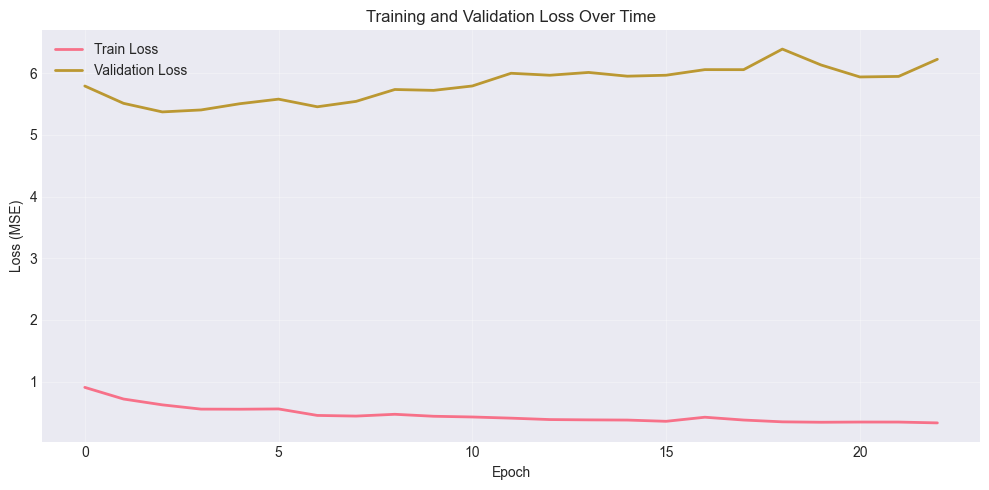

In [30]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Evaluate Model on Test Set

In [31]:
# Load best model
checkpoint = torch.load('../model/internal/v1/internal_model_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
test_loss = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss (MSE): {test_loss:.6f}")

Loaded best model from epoch 3

Test Loss (MSE): 0.451569


In [32]:
# Get predictions on test set
model.eval()
y_pred_scaled = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        y_pred_scaled.append(pred.cpu().numpy())

y_pred_scaled = np.vstack(y_pred_scaled)

# Inverse transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

print(f"Predictions shape: {y_pred.shape}")

Predictions shape: (183, 5)


## 13. Calculate Evaluation Metrics

In [33]:
# Calculate metrics for each target parameter
print("=" * 80)
print("EVALUATION METRICS (Test Set)")
print("=" * 80)

for i, param in enumerate(TARGET_PARAMS):
    y_true = y_test_original[:, i]
    y_pred_param = y_pred[:, i]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_param))
    mae = mean_absolute_error(y_true, y_pred_param)
    r2 = r2_score(y_true, y_pred_param)
    
    # MAPE (avoid division by zero)
    mape = np.mean(np.abs((y_true - y_pred_param) / (y_true + 1e-8))) * 100
    
    print(f"\n{param.upper()}:")
    print(f"  RMSE: {rmse:10.4f}")
    print(f"  MAE:  {mae:10.4f}")
    print(f"  R²:   {r2:10.4f}")
    print(f"  MAPE: {mape:10.2f}%")

# Overall metrics (averaged)
overall_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
overall_mae = mean_absolute_error(y_test_original, y_pred)
overall_r2 = r2_score(y_test_original, y_pred)

print("\n" + "=" * 80)
print("OVERALL (All Parameters):")
print(f"  RMSE: {overall_rmse:.4f}")
print(f"  MAE:  {overall_mae:.4f}")
print(f"  R²:   {overall_r2:.4f}")
print("=" * 80)

EVALUATION METRICS (Test Set)

CHL_A:
  RMSE:     3.9298
  MAE:      3.0257
  R²:       0.0220
  MAPE:     322.12%

TURBIDITY:
  RMSE:     8.6735
  MAE:      4.0374
  R²:       0.3605
  MAPE:     190.19%

DO_MG_L:
  RMSE:     1.5688
  MAE:      0.9604
  R²:      -0.1316
  MAPE:      10.91%

N_TOTAL:
  RMSE:   127.9553
  MAE:     97.4838
  R²:       0.6465
  MAPE:      30.04%

TEMPERATURE:
  RMSE:     2.2778
  MAE:      1.7863
  R²:       0.7346
  MAPE:      11.47%

OVERALL (All Parameters):
  RMSE: 57.3949
  MAE:  21.4587
  R²:   0.3264


## 14. Visualize Predictions vs Actual

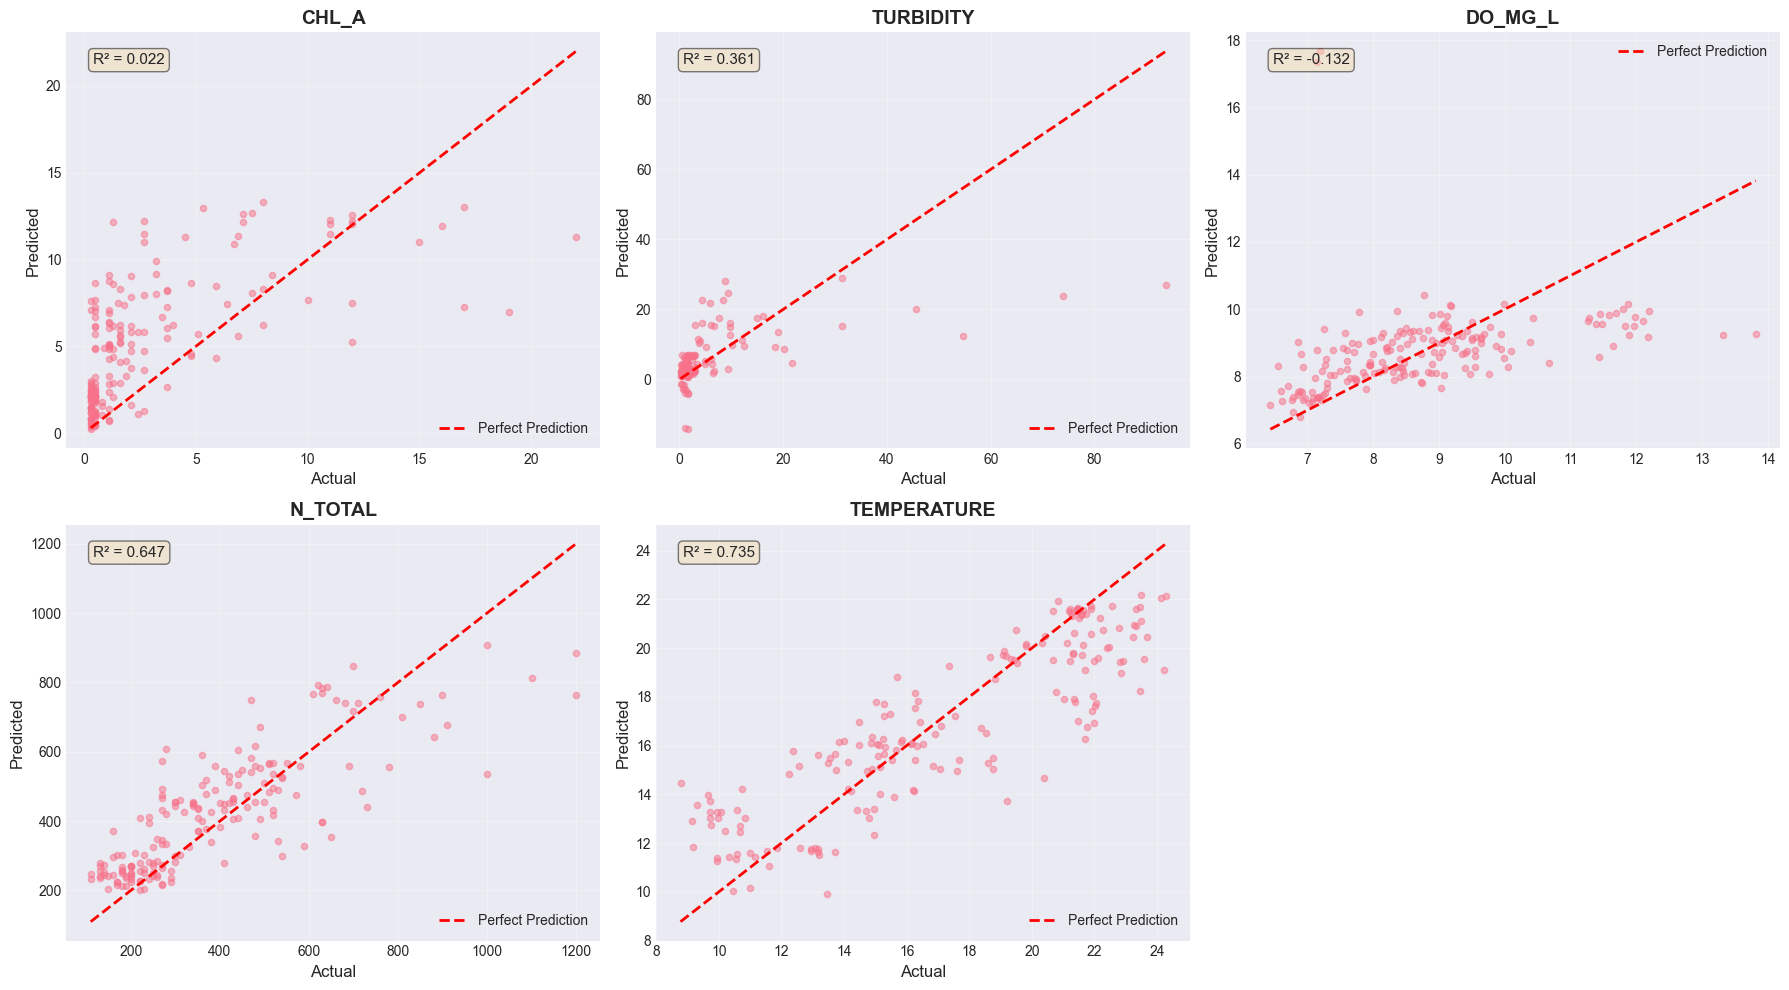

In [34]:
# Scatter plots: Predicted vs Actual for each parameter
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(TARGET_PARAMS):
    y_true = y_test_original[:, i]
    y_pred_param = y_pred[:, i]
    
    axes[i].scatter(y_true, y_pred_param, alpha=0.5, s=20)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', linewidth=2, label='Perfect Prediction')
    axes[i].set_xlabel('Actual', fontsize=12)
    axes[i].set_ylabel('Predicted', fontsize=12)
    axes[i].set_title(f'{param.upper()}', fontsize=14, fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add R² to plot
    r2 = r2_score(y_true, y_pred_param)
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', 
                transform=axes[i].transAxes, 
                fontsize=11, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove extra subplot
if len(TARGET_PARAMS) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 15. Residual Analysis

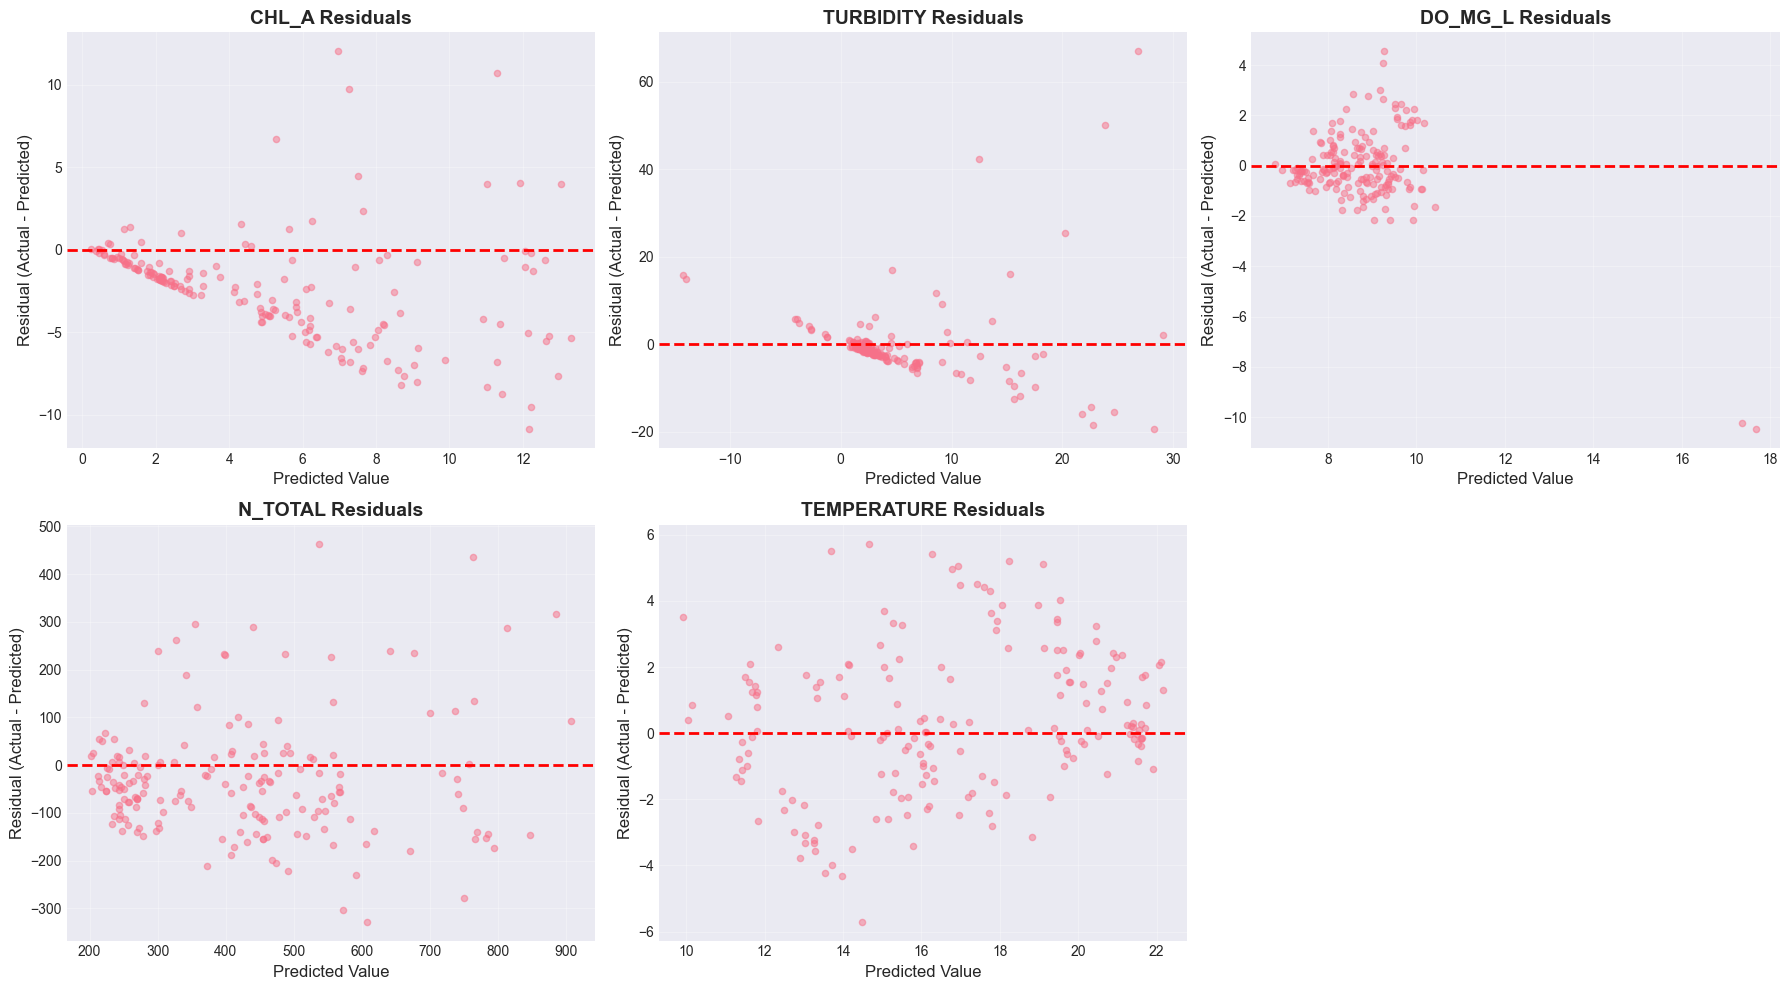

In [35]:
# Residual plots for each parameter
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(TARGET_PARAMS):
    y_true = y_test_original[:, i]
    y_pred_param = y_pred[:, i]
    residuals = y_true - y_pred_param
    
    axes[i].scatter(y_pred_param, residuals, alpha=0.5, s=20)
    axes[i].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Predicted Value', fontsize=12)
    axes[i].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
    axes[i].set_title(f'{param.upper()} Residuals', fontsize=14, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
if len(TARGET_PARAMS) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 16. Save Model and Artifacts

In [36]:
# Save final model with metadata
import pickle

model_artifact = {
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': INPUT_DIM,
        'hidden_dims': HIDDEN_DIMS,
        'output_dim': OUTPUT_DIM,
        'dropout': DROPOUT,
    },
    'feature_cols': FEATURE_COLS,
    'target_params': TARGET_PARAMS,
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'site_encoder': site_encoder,
    'water_body_encoder': water_body_encoder,
    'training_history': history,
    'test_metrics': {
        'rmse': overall_rmse,
        'mae': overall_mae,
        'r2': overall_r2,
    },
}

torch.save(model_artifact, '../model/internal/v1/internal_model_complete.pth')
print("✓ Complete model artifact saved to: ../model/internal/v1/internal_model_complete.pth")

# Also save scalers separately for backend integration
with open('../model/internal/v1/scalers.pkl', 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'site_encoder': site_encoder,
        'water_body_encoder': water_body_encoder,
    }, f)
print("✓ Scalers saved to: ../model/internal/v1/scalers.pkl")

✓ Complete model artifact saved to: ../model/internal/v1/internal_model_complete.pth
✓ Scalers saved to: ../model/internal/v1/scalers.pkl


## 17. Summary & Next Steps

In [37]:
print("=" * 80)
print("MODEL DEVELOPMENT SUMMARY - INTERNAL MODEL")
print("=" * 80)
print(f"\nModel Type: Multi-Layer Perceptron (MLP)")
print(f"Architecture: {INPUT_DIM} → {' → '.join(map(str, HIDDEN_DIMS))} → {OUTPUT_DIM}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nFeatures Used: {len(FEATURE_COLS)}")
print(f"  - Site & Location: 4")
print(f"  - Temporal: 8")
print(f"  - Site Statistics: {sum(1 for c in FEATURE_COLS if any(s in c for s in ['_mean', '_std', '_min', '_max', '_median']))}")
print(f"  - Lag Features: {sum(1 for c in FEATURE_COLS if '_lag' in c)}")
print(f"  - Rolling Features: {sum(1 for c in FEATURE_COLS if '_rolling_' in c)}")
print(f"\nDataset:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Test:  {len(X_test)} samples")
print(f"\nTest Set Performance:")
print(f"  Overall RMSE: {overall_rmse:.4f}")
print(f"  Overall MAE:  {overall_mae:.4f}")
print(f"  Overall R²:   {overall_r2:.4f}")
print(f"\nModel saved to: ../model/internal/v1/internal_model_complete.pth")
print("\n" + "=" * 80)
print("NEXT STEPS:")
print("=" * 80)
print("1. Analyze per-parameter performance and identify weak predictions")
print("2. Experiment with different architectures (LSTM, Attention)")
print("3. Incorporate external data (weather, tides) for external model")
print("4. Build hybrid model combining internal + external features")
print("5. Integrate best model with backend API for predictions")
print("6. Deploy model for frontend consumption")
print("=" * 80)

MODEL DEVELOPMENT SUMMARY - INTERNAL MODEL

Model Type: Multi-Layer Perceptron (MLP)
Architecture: 72 → 256 → 128 → 64 → 5
Total Parameters: 60165

Features Used: 72
  - Site & Location: 4
  - Temporal: 8
  - Site Statistics: 45
  - Lag Features: 15
  - Rolling Features: 20

Dataset:
  Train: 847 samples
  Val:   181 samples
  Test:  183 samples

Test Set Performance:
  Overall RMSE: 57.3949
  Overall MAE:  21.4587
  Overall R²:   0.3264

Model saved to: ../model/internal/v1/internal_model_complete.pth

NEXT STEPS:
1. Analyze per-parameter performance and identify weak predictions
2. Experiment with different architectures (LSTM, Attention)
3. Incorporate external data (weather, tides) for external model
4. Build hybrid model combining internal + external features
5. Integrate best model with backend API for predictions
6. Deploy model for frontend consumption
